In [56]:
import numpy as np
import pandas as pd
import os 
from scipy.stats import expon, uniform, beta, gamma
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time
from copy import deepcopy
from itertools import product
from functools import partial
import networkx as nx

from InfluenceDiffusion.Graph import Graph
from InfluenceDiffusion.influence_models import LTM, GLTM
from InfluenceDiffusion.estimation_models.OptimEstimation import GLTWeightEstimator
from InfluenceDiffusion.weight_samplers import make_random_weights_with_indeg_constraint

os.chdir("/Users/amkagan/Desktop/gltm_experiments")

from utils.trace_utils import trace_train_test_split
from utils.utils import plot_distribution, RMAE
from utils.model_evaluation_utils import compare_metric_over_bins, make_heatmap

## Define graph & sample traces

In [13]:
n_nodes = 100
p = 0.1

random_state = 5

g = nx.erdos_renyi_graph(n_nodes, p=p, seed=random_state, directed=True)
g = Graph(g.edges)

true_weights = make_random_weights_with_indeg_constraint(g, random_state=random_state)
# true_weights = generate_edge_weights_with_fixed_avg_indeg(g, avg_indeg=inv_indeg_coef, noise_eps=noise_eps)

g.set_weights(true_weights)

# sns.heatmap(g.get_adj_matrix())
# plt.show()

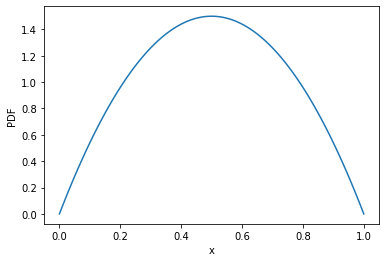

In [14]:
a, b = 2, 2
true_distrib = beta(a, b) #mean is a / (a + b)
plot_distribution(true_distrib)
mean = true_distrib.mean()

In [15]:
n_traces = 2000
max_seed_size = 10
seed_size_range=range(1, max_seed_size + 1)

true_ltm = LTM(g, threshold_generator=true_distrib, random_state=random_state)
traces = true_ltm.sample_traces(n_traces=n_traces, seed_size_range=seed_size_range)
# edge_activations = make_report_traces(traces, min_edge_participation=1)

In [16]:
train_traces, test_traces = trace_train_test_split(traces, test_ratio=0.2)
test_seeds = [test_trace[0] for test_trace in test_traces]
len(train_traces), len(test_traces)

(1600, 400)

## 1. Experiments
### 1.1 Beta distribution comparison

In [17]:
save_name = \
f"ER_a{a}_b{b}_{n_nodes}_seed_{max_seed_size}_p_{p}_traces_{n_traces}_random_state_{random_state}"

In [18]:
def RMSE(y_pred, y_true):
    return np.sqrt(np.mean((y_pred - y_true) ** 2))

In [25]:
def weight_estimation_from_distrib(distrib, g=g, traces=train_traces):
    vertex_2_distrib = {vertex: distrib for vertex in g.get_vertices()}
    ltm_estimator = GLTWeightEstimator(g, vertex_2_distrib=vertex_2_distrib, n_jobs=8)
    weights = ltm_estimator.fit(traces)
    ll = - ltm_estimator._compute_total_nll(weights)
    return weights, ll

In [42]:
a_range = np.linspace(1, 3, 9)
b_range = np.linspace(1, 3, 9)

ab_pairs = np.array(list(product(a_range, b_range)))
beta_distribs = [beta(*ab_pair) for ab_pair in ab_pairs]

In [ ]:
weight_ll_pairs = list(tqdm(map(weight_estimation_from_distrib, beta_distribs), 
                             total=len(beta_distribs)))
weights_list, lls = zip(*weight_ll_pairs)
    
np.save(f"saved_weights/beta_ab_weights_{save_name}", weights_list)

  2%|█                                           | 2/81 [00:18<12:14,  9.30s/it]

In [43]:
weight_ll_pairs = list(tqdm(map(weight_estimation_from_distrib, beta_distribs), 
                             total=len(beta_distribs)))
weights_list, lls = zip(*weight_ll_pairs)
    
# np.save(f"saved_results/beta_ab_weights_{save_name}", weights_list)

In [ ]:
weights_list = np.load(f"saved_results/beta_ab_weights_{save_name}.npy")

In [32]:
def compute_test_ll(idx, g=g, test_traces=test_traces):
    distrib, weights = beta_distribs[idx], weights_list[idx]
    vertex_2_distrib = {vertex: distrib for vertex in g.get_vertices()}
    ltm_estimator = GLTWeightEstimator(g, n_jobs=8)
    ltm_estimator._pre_fit(test_traces)
    return - ltm_estimator._compute_total_nll(weights)

In [44]:
test_lls = list(tqdm(map(compute_test_ll, range(len(beta_distribs))), 
                                 total=len(beta_distribs)))

In [16]:
a_best, b_best = ab_pairs[np.argmax(test_lls)]
print(f"The highest likelihood achieved for a={a_best}, b={b_best}")

The highest likelihood achieved for a=2, b=2


In [137]:
# rand_weights = true_weights * np.random.uniform(0.8, 1.2, len(true_weights))
# WeightEstimatorGLTM(g, beta(2,2))._compute_nll(rand_weights)

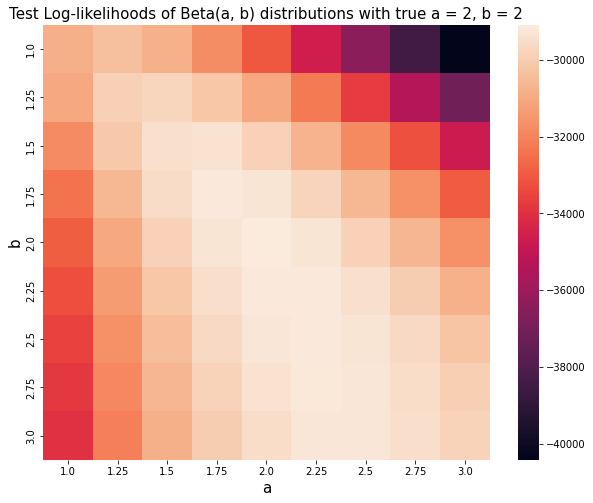

In [50]:
make_heatmap(test_lls, ab_pairs, 
             title=f"Test Log-likelihoods of Beta(a, b) distributions with true a = {a}, b = {b}")

In [37]:
num_runs_per_seed = 100

def compute_avg_spread_over_seeds(distrib, weights, seeds, g, 
                                  num_runs_per_seed=num_runs_per_seed, n_jobs=None):
    g_copy = deepcopy(g)
    g_copy.set_weights(weights)
    distrib_dict = {v: distrib for v in g.get_vertices()}
    model = GLTM(g_copy, distrib_dict, check_init=True, n_jobs=n_jobs)
    spreads = [model.estimate_spread(seed, n_runs=num_runs_per_seed) 
               for seed in seeds]
    return np.array(spreads)

In [38]:
true_test_spread = np.array([len(trace.get_all_activated_vertices()) for trace in test_traces])

In [54]:
ab_2_pred_spread = {tuple(ab_pair): compute_avg_spread_over_seeds(distrib, weights, seeds=test_seeds, g=g) 
                              for ab_pair, distrib, weights in tqdm(zip(ab_pairs, 
                                                                        beta_distribs, 
                                                                        weights_list))}

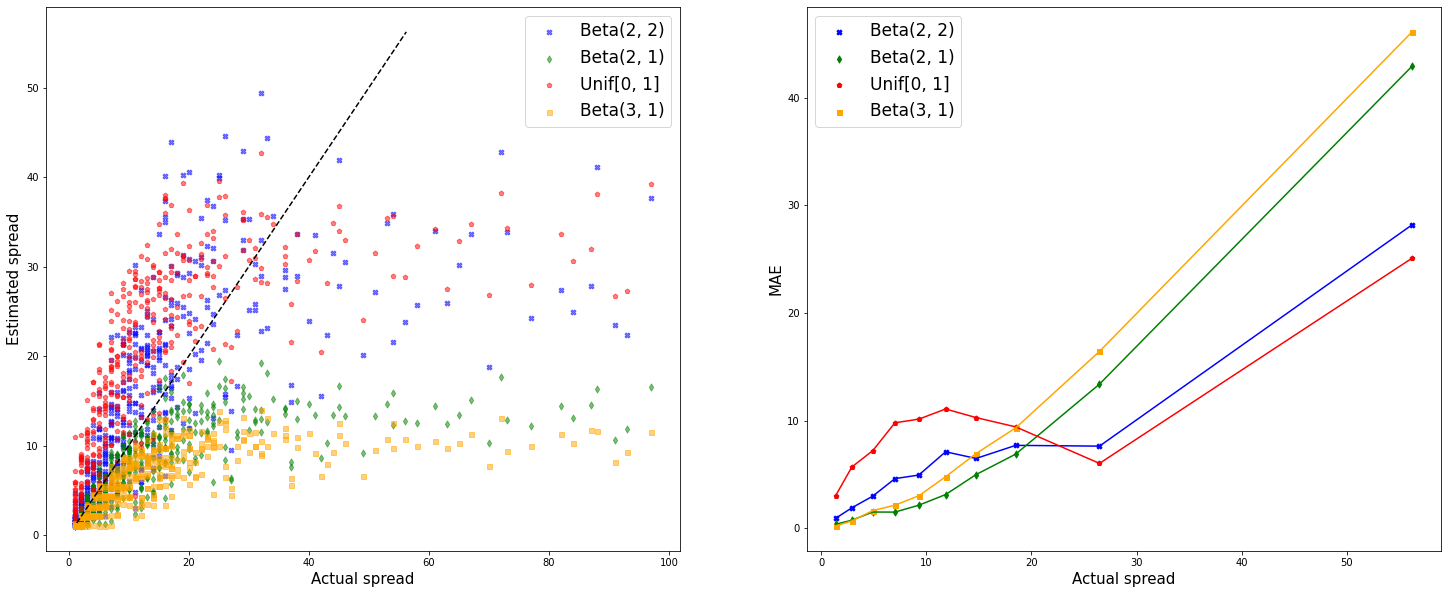

In [52]:
selected_ab_pairs = [(2, 2), (2, 1), (1, 1), (3, 1)]
selected_pred_spreads = [ab_2_pred_spread[ab] for ab in selected_ab_pairs]
ab_legend_pairs = ["Unif[0, 1]" if (a == 1 and b == 1) else f"Beta({a}, {b})" 
                   for (a, b) in selected_ab_pairs ]

compare_metric_over_bins(true_test_spread, selected_pred_spreads, metric=mean_absolute_error,
                         pred_names=ab_legend_pairs, bins=10,
                         markersize=25, colors=["b", "g", "r", "orange"])